In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os, pickle, psutil
from pympler import asizeof

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,roc_curve, auc, f1_score)
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, RFECV

from imblearn.over_sampling import SMOTE

In [6]:

data_path = "clean_dataset_malware2.csv"  
df = pd.read_csv(data_path)

print("Data shape:", df.shape)
print(df.head())

# Removing duplicates and fill missing values
df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)

# Map "Class": values < 5 become 1 (malicious), value 5 becomes 0 (benign)
df['Class'] = df['Class'].apply(lambda x: 1 if x < 5 else 0)
print("\nClass Distribution:")
print(df['Class'].value_counts())

# Split features and target
X = df.drop(columns=['Class'])
y = df['Class']
print("X shape:", X.shape)
print("y shape:", y.shape)

Data shape: (11526, 392)
   ACCESS_PERSONAL_INFO___  ALTER_PHONE_STATE___  ANTI_DEBUG_____  \
0                        1                     0                0   
1                        3                     0                0   
2                        2                     0                0   
3                        1                     0                0   
4                        3                     0                0   

   CREATE_FOLDER_____  CREATE_PROCESS`_____  CREATE_THREAD_____  \
0                   3                     0                  14   
1                   6                     0                  42   
2                   4                     0                  23   
3                   4                     0                  27   
4                  11                     0                  18   

   DEVICE_ACCESS_____  EXECUTE_____  FS_ACCESS____  FS_ACCESS()____  ...  \
0                   2             0              3                0  ...   
1    

In [7]:
# Train-Test Split & Scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Train shape: (9220, 391) Test shape: (2306, 391)


In [8]:
# Apply SMOTE on Training Data

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE, training class distribution:")
print(pd.Series(y_train_smote).value_counts())


After SMOTE, training class distribution:
Class
1    7787
0    7787
Name: count, dtype: int64


In [9]:
# Feature Selection: Tree-Based + RFECV Refinement

print("\n--- Feature Selection: Tree-Based Importance ---")
tree_estimator = RandomForestClassifier(n_estimators=50, random_state=42)
tree_estimator.fit(X_train_smote, y_train_smote)
sfm = SelectFromModel(tree_estimator, threshold="median", prefit=True)
X_train_tree = sfm.transform(X_train_smote)
X_test_tree = sfm.transform(X_test_scaled)
print("Tree-based selected features shape - Train:", X_train_tree.shape, 
      "Test:", X_test_tree.shape)

print("\n--- RFECV on Tree-Based Selected Features ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_for_rfecv = RandomForestClassifier(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf_for_rfecv, step=5, cv=cv, scoring='accuracy', min_features_to_select=195, n_jobs=-1)
rfecv.fit(X_train_tree, y_train_smote)
print("RFECV selected {} features out of {}.".format(rfecv.n_features_, X_train_tree.shape[1]))

# Final selected feature set for training and testing
X_train_final = X_train_tree[:, rfecv.support_]
X_test_final = X_test_tree[:, rfecv.support_]
print("Final feature set shape after RFECV - X_train:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)
print("y_test length:", len(y_test))


--- Feature Selection: Tree-Based Importance ---
Tree-based selected features shape - Train: (15574, 196) Test: (2306, 196)

--- RFECV on Tree-Based Selected Features ---
RFECV selected 195 features out of 196.
Final feature set shape after RFECV - X_train: (15574, 195)
X_test_final shape: (2306, 195)
y_test length: 2306


In [11]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

# --- (your existing RF training & evaluation) ---
print("\n--- Training Random Forest on Final Feature Set ---")
param_grid_rf = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20]}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5,
                       scoring='accuracy', n_jobs=-1, verbose=1)

start_time = time.time()
grid_rf.fit(X_train_final, y_train_smote)
rf_train_time = time.time() - start_time

print("Random Forest - Best Parameters:", grid_rf.best_params_)
print("Random Forest - Best CV Accuracy: {:.4f}".format(grid_rf.best_score_))

y_pred_rf = grid_rf.predict(X_test_final)
y_pred_rf_proba = grid_rf.predict_proba(X_test_final)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)
print("Random Forest - Test Accuracy: {:.4f}".format(acc_rf))
print("Random Forest - Test ROC-AUC: {:.4f}".format(auc_rf))
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))

final_rf = grid_rf.best_estimator_

# --- Threshold tuning ---
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_f1 = 0

for thresh in thresholds:
    y_thr = (y_pred_rf_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_thr)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

print("\nOptimal decision threshold for RF:", best_thresh)
print("F1 Score at optimal threshold: {:.4f}".format(best_f1))

# Evaluate at that threshold
y_pred_opt = (y_pred_rf_proba >= best_thresh).astype(int)
acc_opt = accuracy_score(y_test, y_pred_opt)
auc_opt = roc_auc_score(y_test, y_pred_rf_proba)

print("RF Test Accuracy at optimal threshold: {:.4f}".format(acc_opt))
print("RF Test ROC-AUC (probabilities): {:.4f}".format(auc_opt))
print("\nRF Classification Report (threshold = {}):\n".format(best_thresh),
      classification_report(y_test, y_pred_opt))



--- Training Random Forest on Final Feature Set ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Random Forest - Best Parameters: {'max_depth': None, 'n_estimators': 150}
Random Forest - Best CV Accuracy: 0.9891
Random Forest - Test Accuracy: 0.9783
Random Forest - Test ROC-AUC: 0.9961
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.98      0.98      0.98      2306


Optimal decision threshold for RF: 0.48
F1 Score at optimal threshold: 0.9877
RF Test Accuracy at optimal threshold: 0.9792
RF Test ROC-AUC (probabilities): 0.9961

RF Classification Report (threshold = 0.48):
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       359
         

In [12]:

from xgboost import XGBClassifier
print("\n--- Training XGBoost on Final Feature Set ---")
param_grid_xgb = {'n_estimators': [150, 200, 250],'max_depth': [3, 5, 7],'learning_rate': [0.01, 0.05, 0.1],'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0]}
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
start_time = time.time()
grid_xgb.fit(X_train_final, y_train_smote)
xgb_train_time = time.time() - start_time
print("XGBoost - Best Parameters:", grid_xgb.best_params_)
print("XGBoost - Best CV Accuracy: {:.4f}".format(grid_xgb.best_score_))
y_pred_xgb = grid_xgb.predict(X_test_final)
y_pred_xgb_proba = grid_xgb.predict_proba(X_test_final)[:, 1]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print("XGBoost - Test Accuracy: {:.4f}".format(acc_xgb))
print("XGBoost - Test ROC-AUC: {:.4f}".format(auc_xgb))
print("XGBoost - Classification Report:\n", classification_report(y_test, y_pred_xgb))
final_xgb = grid_xgb.best_estimator_

# XGBoost Threshold Tuning 
print("\n--- XGBoost Threshold Tuning ---")
# Get predicted probabilities for the positive class
y_pred_proba_xgb = final_xgb.predict_proba(X_test_final)[:, 1]
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_f1 = 0
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_xgb >= thresh).astype(int)
    current_f1 = f1_score(y_test, y_pred_thresh)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh
print("Optimal threshold for XGBoost:", best_thresh)
print("F1 Score at optimal threshold: {:.4f}".format(best_f1))
# Evaluate XGBoost with the optimal threshold
y_pred_xgb_thresh = (y_pred_proba_xgb >= best_thresh).astype(int)
acc_xgb_thresh = accuracy_score(y_test, y_pred_xgb_thresh)
print("XGBoost Test Accuracy at optimal threshold: {:.4f}".format(acc_xgb_thresh))
print("XGBoost Classification Report with threshold tuning:\n", classification_report(y_test, y_pred_xgb_thresh))


--- Training XGBoost on Final Feature Set ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.8}
XGBoost - Best CV Accuracy: 0.9845
XGBoost - Test Accuracy: 0.9822
XGBoost - Test ROC-AUC: 0.9970
XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.97      0.96      0.97      2306
weighted avg       0.98      0.98      0.98      2306


--- XGBoost Threshold Tuning ---
Optimal threshold for XGBoost: 0.39999999999999997
F1 Score at optimal threshold: 0.9898
XGBoost Test Accuracy at optimal threshold: 0.9827
XGBoost Classification Report with threshold tuning:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       359
           1       0.99      0.99      0.99      1947

    accuracy       

In [13]:
import numpy as np
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier

print("\n--- Training CatBoost on Final Feature Set (with GridSearchCV) ---")

# 1. Define CatBoost and parameter grid
cat = CatBoostClassifier(random_state=42, verbose=0)
param_grid_cat = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# 2. GridSearchCV setup
grid_cat = GridSearchCV(
    estimator=cat,
    param_grid=param_grid_cat,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Fit and time it
start_time = time.time()
grid_cat.fit(X_train_final, y_train_smote)
cat_train_time = time.time() - start_time

print("CatBoost - Best Parameters:", grid_cat.best_params_)
print("CatBoost - Best CV Accuracy: {:.4f}".format(grid_cat.best_score_))

# 4. Evaluate on test set
best_cat = grid_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test_final)
y_pred_cat_proba = best_cat.predict_proba(X_test_final)[:, 1]

acc_cat = accuracy_score(y_test, y_pred_cat)
auc_cat = roc_auc_score(y_test, y_pred_cat_proba)
print("CatBoost - Test Accuracy: {:.4f}".format(acc_cat))
print("CatBoost - Test ROC-AUC: {:.4f}".format(auc_cat))
print("CatBoost - Classification Report:\n", classification_report(y_test, y_pred_cat))

# 5. Threshold tuning
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_f1 = 0

for thresh in thresholds:
    y_thr = (y_pred_cat_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_thr)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

print("\nOptimal decision threshold for CatBoost:", best_thresh)
print("F1 Score at optimal threshold: {:.4f}".format(best_f1))

# 6. Re-evaluate at optimal threshold
y_pred_opt = (y_pred_cat_proba >= best_thresh).astype(int)
acc_opt = accuracy_score(y_test, y_pred_opt)
auc_opt = roc_auc_score(y_test, y_pred_cat_proba)

print("CatBoost Test Accuracy at optimal threshold: {:.4f}".format(acc_opt))
print("CatBoost Test ROC-AUC (probabilities): {:.4f}".format(auc_opt))
print("\nCatBoost Classification Report (threshold = {}):\n".format(best_thresh),
      classification_report(y_test, y_pred_opt))



--- Training CatBoost on Final Feature Set (with GridSearchCV) ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
CatBoost - Best Parameters: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoost - Best CV Accuracy: 0.9848
CatBoost - Test Accuracy: 0.9796
CatBoost - Test ROC-AUC: 0.9965
CatBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       359
           1       0.98      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.97      0.95      0.96      2306
weighted avg       0.98      0.98      0.98      2306


Optimal decision threshold for CatBoost: 0.58
F1 Score at optimal threshold: 0.9885
CatBoost Test Accuracy at optimal threshold: 0.9805
CatBoost Test ROC-AUC (probabilities): 0.9965

CatBoost Classification Report (threshold = 0.58):
               precision    recall  f1-score   support

           0    

In [14]:
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

print("\n--- Training Logistic Regression on Final Feature Set (with GridSearchCV) ---")

# 1. Define base model and parameter grid
lr = LogisticRegression(solver='liblinear', random_state=42)
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
}

# 2. GridSearchCV setup
grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Fit and time it
start_time = time.time()
grid_lr.fit(X_train_final, y_train_smote)
lr_train_time = time.time() - start_time

print("LogReg - Best Parameters:", grid_lr.best_params_)
print("LogReg - Best CV Accuracy: {:.4f}".format(grid_lr.best_score_))

# 4. Evaluate on test set
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_final)
y_pred_lr_proba = best_lr.predict_proba(X_test_final)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)
print("Logistic Regression - Test Accuracy: {:.4f}".format(acc_lr))
print("Logistic Regression - Test ROC-AUC: {:.4f}".format(auc_lr))
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred_lr))

# 5. Threshold tuning
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_f1 = 0

for thresh in thresholds:
    y_thr = (y_pred_lr_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_thr)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh

print("\nOptimal decision threshold for LogReg:", best_thresh)
print("F1 Score at optimal threshold: {:.4f}".format(best_f1))

# 6. Re-evaluate at optimal threshold
y_pred_opt = (y_pred_lr_proba >= best_thresh).astype(int)
acc_opt = accuracy_score(y_test, y_pred_opt)
auc_opt = roc_auc_score(y_test, y_pred_lr_proba)

print("LogReg Test Accuracy at optimal threshold: {:.4f}".format(acc_opt))
print("LogReg Test ROC-AUC (probabilities): {:.4f}".format(auc_opt))
print("\nLogistic Regression Classification Report (threshold = {}):\n".format(best_thresh),
      classification_report(y_test, y_pred_opt))



--- Training Logistic Regression on Final Feature Set (with GridSearchCV) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LogReg - Best Parameters: {'C': 10, 'penalty': 'l1'}
LogReg - Best CV Accuracy: 0.9366
Logistic Regression - Test Accuracy: 0.9523
Logistic Regression - Test ROC-AUC: 0.9571
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       359
           1       0.97      0.97      0.97      1947

    accuracy                           0.95      2306
   macro avg       0.91      0.92      0.91      2306
weighted avg       0.95      0.95      0.95      2306


Optimal decision threshold for LogReg: 0.3
F1 Score at optimal threshold: 0.9783
LogReg Test Accuracy at optimal threshold: 0.9631
LogReg Test ROC-AUC (probabilities): 0.9571

Logistic Regression Classification Report (threshold = 0.3):
               precision    recall  f1-score   support

           0       0

c:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
# Saving Final Models 

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(final_rf, f)
with open('best_final_xgb_model.pkl', 'wb') as f:
    pickle.dump(final_xgb, f)
with open('cat_model.pkl', 'wb') as f:
    pickle.dump(best_cat, f)
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(best_lr, f)


--- Plotting ROC Curves ---


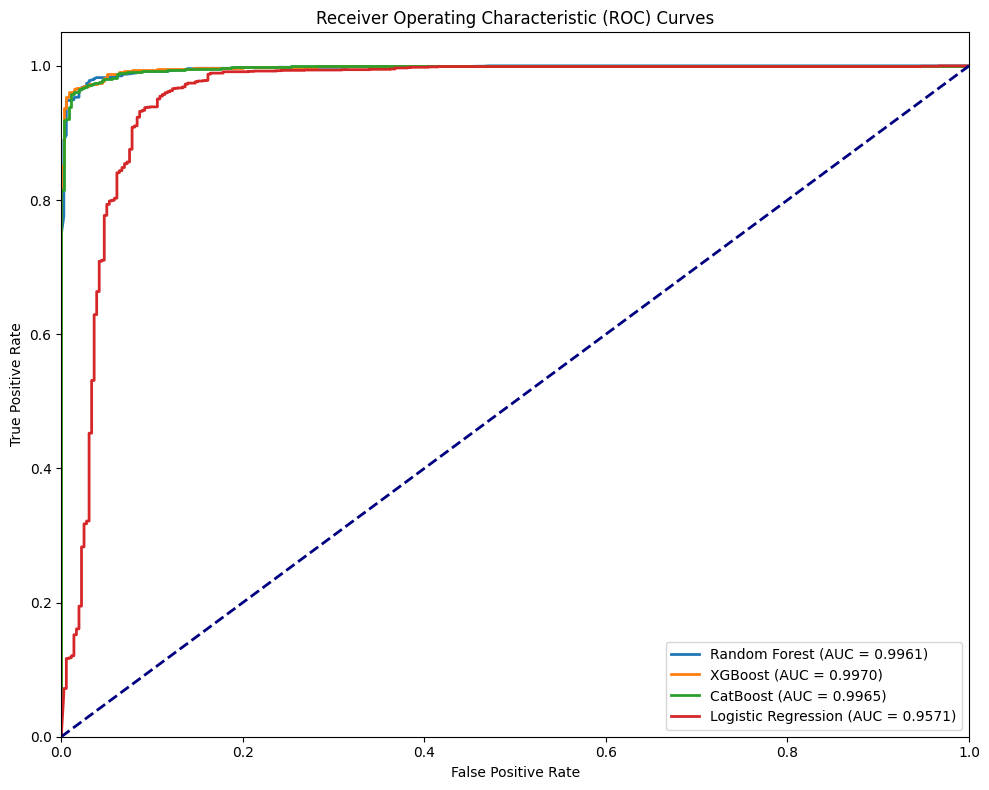

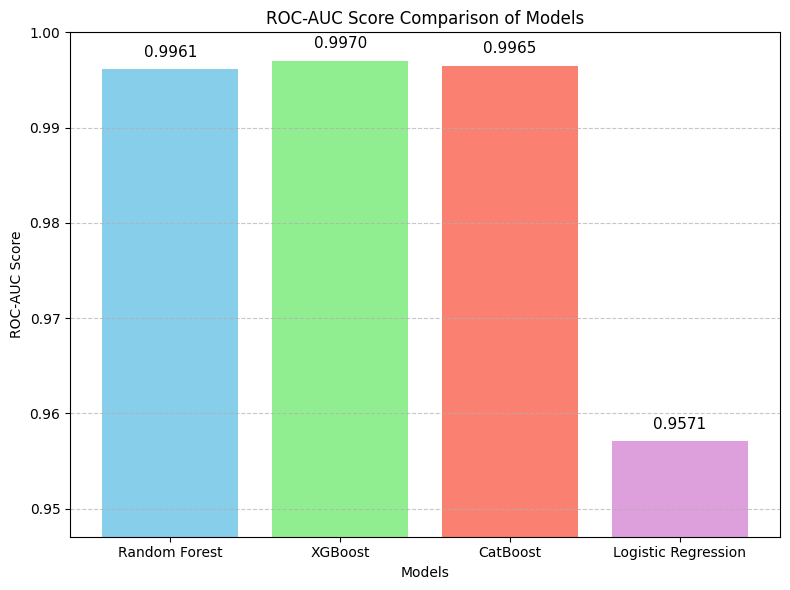

In [16]:
# Plotting ROC Curves for All Models

print("\n--- Plotting ROC Curves ---")
plt.figure(figsize=(10, 8))

models_dict = {
    'Random Forest': final_rf,
    'XGBoost': final_xgb,
    'CatBoost': best_cat,
    'Logistic Regression': best_lr
}

for name, model in models_dict.items():
    y_proba = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {model_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300)
plt.show()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Compute ROC-AUC scores for all models
roc_auc_scores = {}

for name, model in models_dict.items():
    y_proba = model.predict_proba(X_test_final)[:, 1]
    score = roc_auc_score(y_test, y_proba)
    roc_auc_scores[name] = score

# Plotting the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(roc_auc_scores.keys(), roc_auc_scores.values(), color=['skyblue', 'lightgreen', 'salmon', 'plum'])

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# Adjust y-axis limits to zoom into the range of AUC scores for clear differentiation
plt.ylim([min(roc_auc_scores.values()) - 0.01, 1.0])

plt.title('ROC-AUC Score Comparison of Models')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("roc_auc_bar_graph.png", dpi=300)
plt.show()


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Compute ROC-AUC scores for all models
roc_auc_scores = {}

for name, model in models_dict.items():
    y_proba = model.predict_proba(X_test_final)[:, 1]
    score = roc_auc_score(y_test, y_proba)
    roc_auc_scores[name] = score

# Plotting the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(roc_auc_scores.keys(), roc_auc_scores.values(), color=['skyblue', 'lightgreen', 'salmon', 'plum'])

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# Adjust y-axis limits to zoom into the range of AUC scores for clear differentiation
plt.ylim([min(roc_auc_scores.values()) - 0.01, 1.0])

plt.title('ROC-AUC Score Comparison of Models')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("roc_auc_bar_graph.png", dpi=300)
plt.show()


NameError: name 'models_dict' is not defined


--- Accuracy Scores ---
Random Forest Accuracy: 0.9783
XGBoost Accuracy: 0.9822
CatBoost Accuracy: 0.9796
Logistic Regression Accuracy: 0.9523

--- Confusion Matrices ---


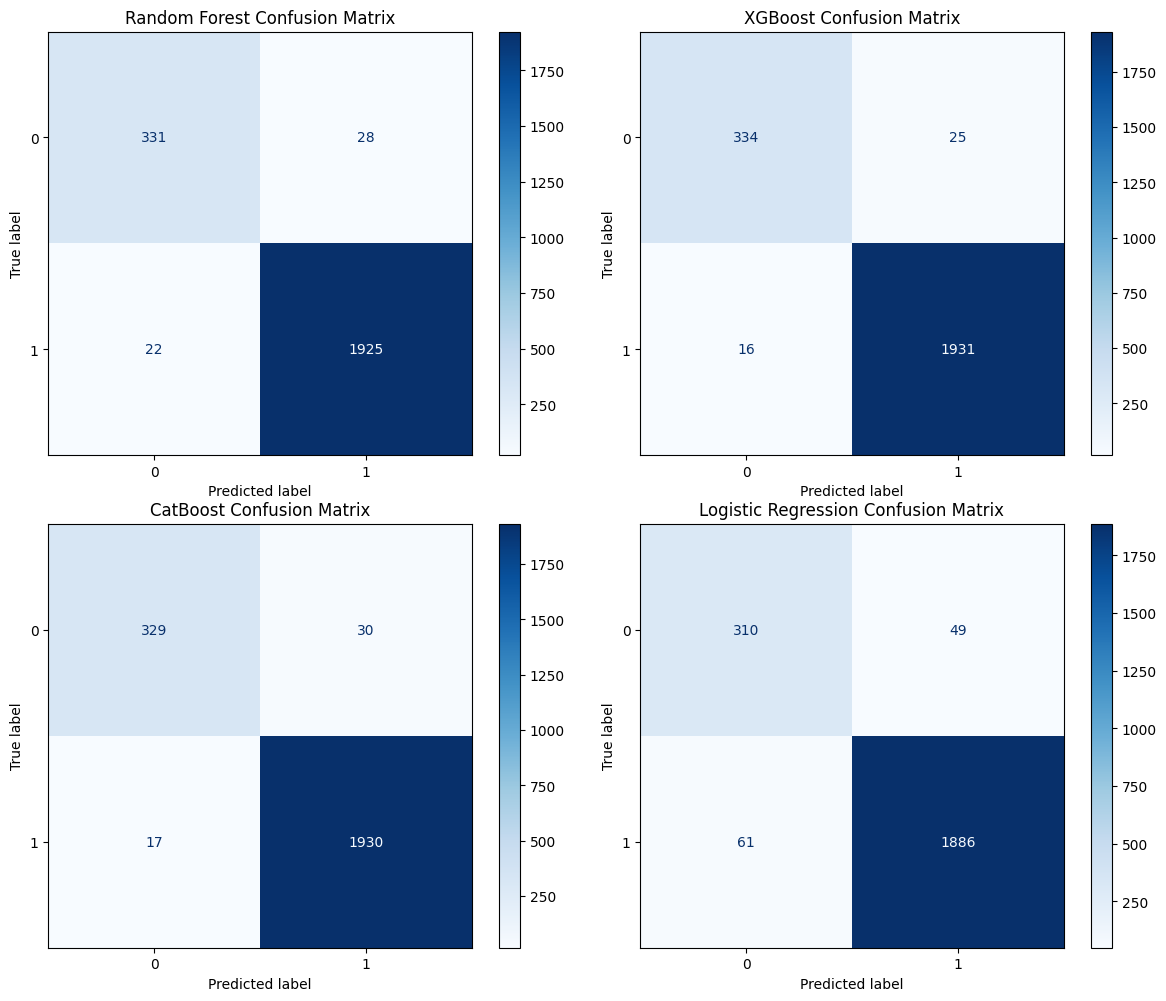

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Accuracy comparison
print("\n--- Accuracy Scores ---")
for name, model in models_dict.items():
    y_pred = model.predict(X_test_final)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')

# Plotting Confusion Matrices
print("\n--- Confusion Matrices ---")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.flatten(), models_dict.items()):
    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, values_format='d', cmap='Blues')
    ax.title.set_text(f'{name} Confusion Matrix')

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=300)
plt.show()


Random Forest - Optimal Threshold: 0.48, Accuracy: 0.9792
XGBoost - Optimal Threshold: 0.39, Accuracy: 0.9827
CatBoost - Optimal Threshold: 0.57, Accuracy: 0.9805

All Optimal Threshold Accuracies:
{'Logistic Regression': 0.9631, 'Random Forest': 0.9791847354726799, 'XGBoost': 0.9826539462272333, 'CatBoost': 0.9804856895056374}


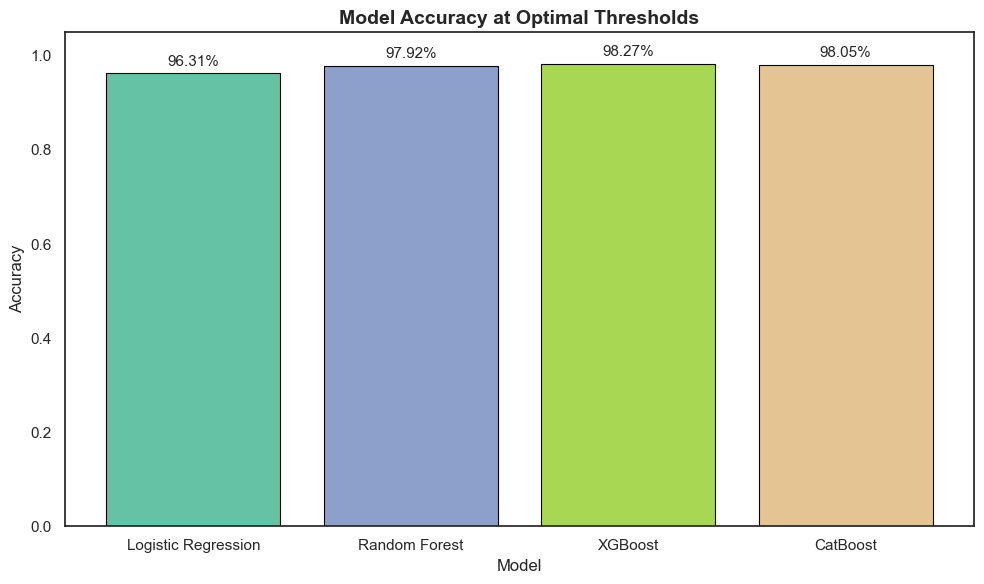

In [31]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Store known Logistic Regression accuracy
optimal_threshold_accuracies = {
    "Logistic Regression": 0.9631
}

# Step 2: Tune thresholds for all other models
for name, model in models_dict.items():
    if name == "Logistic Regression":
        continue  # Skip tuning for Logistic Regression
    
    y_proba = model.predict_proba(X_test_final)[:, 1]
    
    thresholds = np.arange(0.0, 1.01, 0.01)
    best_acc = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred_opt = (y_proba >= threshold).astype(int)
        acc = accuracy_score(y_test, y_pred_opt)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    
    optimal_threshold_accuracies[name] = best_acc
    print(f'{name} - Optimal Threshold: {best_threshold:.2f}, Accuracy: {best_acc:.4f}')

print("\nAll Optimal Threshold Accuracies:")
print(optimal_threshold_accuracies)

# Step 3: Plot with clean styling and percentage labels
models = list(optimal_threshold_accuracies.keys())
accuracies = list(optimal_threshold_accuracies.values())

# Use soft, custom pastel palette
custom_colors = ['#66c2a5', '#8da0cb', '#a6d854', '#e5c494']  # You can expand this if needed

sns.set_style("white")
plt.figure(figsize=(10, 6))

bars = plt.bar(models, accuracies, color=custom_colors[:len(models)], edgecolor='black', linewidth=0.8)

# Add percentage labels (e.g., 96.31%)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    percent_text = f"{acc * 100:.2f}%"
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.01,
             percent_text,
             ha='center', va='bottom', fontsize=11, fontweight='medium')

# Clean layout
plt.ylim(0, 1.05)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Model Accuracy at Optimal Thresholds', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
plt.tight_layout()
plt.show()


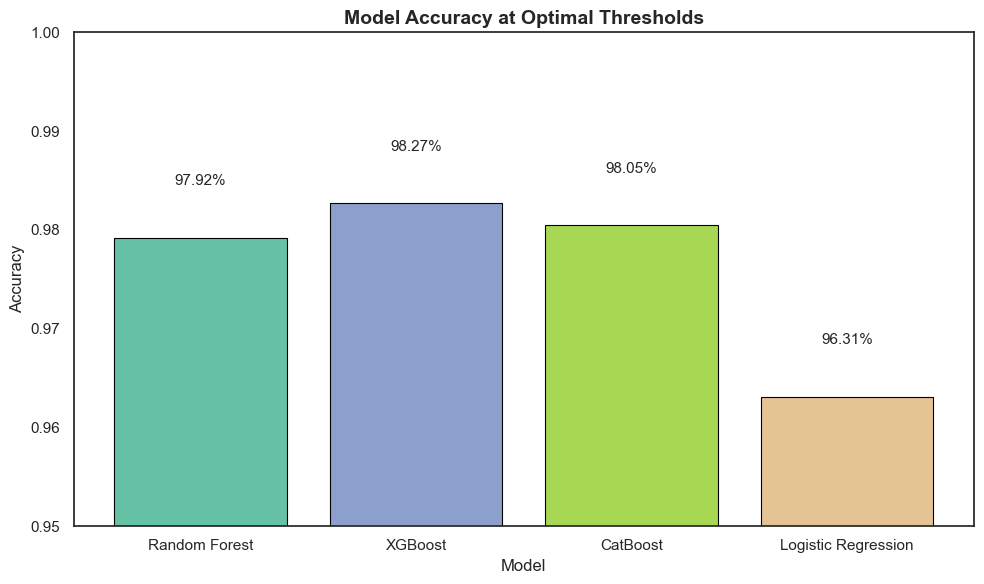

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hardcoded model accuracies after threshold tuning
models = ['Random Forest', 'XGBoost', 'CatBoost', 'Logistic Regression']
accuracies = [0.9792, 0.9827, 0.9805, 0.9631]

# Custom pastel colors
custom_colors = ['#66c2a5', '#8da0cb', '#a6d854', '#e5c494']

# Set clean style
sns.set_style("white")

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=custom_colors, edgecolor='black', linewidth=0.8)

# Add percentage labels on top of bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    percent_str = f"{acc * 100:.2f}%"
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.005,
             percent_str,
             ha='center', va='bottom', fontsize=11, fontweight='medium')

# Axis & layout formatting
plt.ylim(0.95, 1.0)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Model Accuracy at Optimal Thresholds', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
plt.tight_layout()
plt.show()
